# Steepest Descent com critério de Armijo aplicado à função geofísica

O método steepest descent é um método de convergência global, o qual se aproxima do mínimo com a direção de $-\nabla \boldsymbol{\phi}(\mathbf{p})$, que é menos o gradiente da função objetivo e $\mathbf{p}$ é o vetor de parâmentros. Porém, para uma melhor aproximação do mínimo é necessário de um critério mais rigoroso para a escolha da largura do passo. Para isso a chamada regra de Armijo é um exemplo de line search. A condição a ser satisfeita para uma direção mais aceitável é, então:

\begin{equation}
\boldsymbol{\phi}(\mathbf{p}_{k+1}) - \boldsymbol{\phi}(\mathbf{p}_k) < -\alpha \lambda\| \nabla\boldsymbol{\phi}(\mathbf{p}_k) \|^2  ,
\end{equation}

onde $\lambda = \beta^m$, $m \geq 0$ é o menor não-negativo inteiro para uma descida suficiente e $\alpha,\beta$ $\epsilon$ $(0,1)$.

1) estabelece um chute inicial $\mathbf{p}_i$

2) determina a direção $\mathbf{a}_i$ que diminua $\boldsymbol{\phi}$ em torno de $\mathbf{p}_i$

3) calcula $\mathbf{p}_{i+1} = \mathbf{p}_i -\lambda\nabla \boldsymbol{\phi}(\mathbf{p})$

4) verifica a condição de Armijo, enquanto $\boldsymbol{\phi}(\mathbf{p}_{k+1}) - \boldsymbol{\phi}(\mathbf{p}_k) > \alpha \lambda\| \nabla\boldsymbol{\phi}(\mathbf{p}_k) \|^2$:

a) caso não seja satisfeita $m = m + 1$

b) calcula $\lambda = \beta^m$

c) calcula $\mathbf{p}_{+} = \mathbf{p}_i -\lambda\nabla \boldsymbol{\phi}(\mathbf{p})$

d) calcula $\phi(\mathbf{p}_{+})$ e reorna para 4)
 
5) testa a convergência, se for satisfeita o algoritmo para, caso contrário retorna para 1)

# Importando pacotes

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from visual import histeq
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.vis import mpl, myv

import sys
sys.path.insert(0, '../magnetic-radial-inversion/code')

import mag_polyprism_functions as mfun

# Modelagem direta

In [22]:
with open('data/cylinder_model.pickle') as w:
        cylinder_model = pickle.load(w)
with open('data/cylinder_data.pickle') as w:
        cylinder_data = pickle.load(w)
with open('data/regular_grid.pickle') as w:
        regular_grid = pickle.load(w)

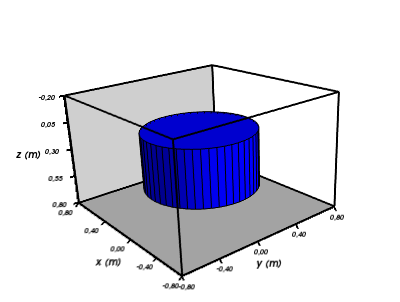

In [23]:
img(filename='bolacha.png')

## Plotando a função

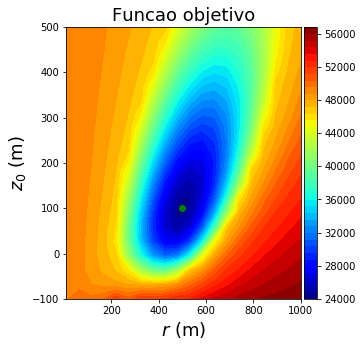

In [24]:
plt.figure(figsize=(5,5))
plt.plot(500., 100., 'og')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], cylinder_data['phi_eq'], 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.savefig('plot_geo_prob.png', pad_inches=0.0)
plt.show()

# Funções

In [25]:
def derivative_tf_z0(xp, yp, zp, prism, M, deltaz, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of one fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    delta: float - increment in x coordinate in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - deltaa
    prism_plus[0].z1 += deltaz
    prism_minus[0].z1 -= deltaz

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltaz)

    return df

def derivative_tf_radiall(xp, yp, zp, prism, M, deltar, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of a fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in radial distance in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    ang = 2.*np.pi/M # angle between two vertices
    
    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - delta

    for i in range(M):
        deltax = deltar*np.cos(i*ang)
        deltay = deltar*np.sin(i*ang)
        prism_plus[0].x[i] += deltax
        prism_plus[0].y[i] += deltay
        prism_minus[0].x[i] -= deltax
        prism_minus[0].y[i] -= deltay

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltar)

    return df

# calculando jacobiana de phi
def jacobi_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec):
    '''
    Returns the sensitivity matrix for polygonal prisms using finite
    differences.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in meters for radial distance
    deltaz: float - increment in meters for depth
    inc: float - inclination of the local-geomagnetic field
    dec: declination of the local-geomagnetic field

    output

    G: 2D array - sensitivity matrix
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    G = np.zeros((xp.size, 2))

    G[:, 0] = derivative_tf_radiall(xp, yp, zp, prism[0], M, deltar, inc, dec)
    G[:, 1] = derivative_tf_z0(xp, yp, zp, prism[0], M, deltaz, inc, dec)

    return G

# Modelo interpretativo

In [26]:
# chute inicial
p01 = 600.
p02 = 330.

# incremento para as derivadas
deltar = 0.001*p01
deltaz = 0.001*p02

r = np.zeros(cylinder_model['M']) + p01 # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, p02, cylinder_model['dz'], cylinder_model['props']]]

In [27]:
prism0 = mfun.pol2cart(l, cylinder_model['M'], cylinder_model['L'])

d0 = polyprism.tf(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'],
                    prism0, cylinder_model['inc'], cylinder_model['dec'])

# vetor do chute inicial
p0 = np.array([p01,p02]) 

# parâmetros para o critério de Armijo
alfa = 0.0001
beta = 0.4
epsilon = 0.0001
mi = 0.0001

# calculando o valor da função e do resíduo em p0
res0 = cylinder_data['data_noise'] - d0
phi0 = np.sum(res0*res0)

p1_list = [p01]
p2_list = [p02]
phi_list = [phi0]

# Algoritmo Steepest Descent com Armijo

In [28]:
for i in range(10000):
    m = 0.
    lamb = 10.4
    
    # calculando a Jacobiana e o gradiente
    G = jacobi_geo(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'], prism0, cylinder_model['M'],
                   deltar, deltaz, cylinder_model['inc'], cylinder_model['dec'])
    grad = -2.*np.dot(G.T, res0) + mi*p0
    
    # calculando p e atualizando para a próxima iteração
    p = p0 - lamb*grad
    l = [[np.zeros(cylinder_model['M']) + p[0], x0, y0, p[1], cylinder_model['dz'], cylinder_model['props']]]
    prism = mfun.pol2cart(l, cylinder_model['M'], cylinder_model['L'])
    d = polyprism.tf(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'],
                    prism, cylinder_model['inc'], cylinder_model['dec'])
    res = cylinder_data['data_noise'] - d
    phi = np.sum(res*res)
    
    while (phi - phi0) > alfa*lamb*np.sum(grad*grad):
        m += 1.
        #print m
        lamb = beta**m
        p = p0 - lamb*grad
        l = [[np.zeros(cylinder_model['M']) + p[0], x0, y0, p[1], cylinder_model['dz'], cylinder_model['props']]]
        prism = mfun.pol2cart(l, cylinder_model['M'], cylinder_model['L'])
        d = polyprism.tf(regular_grid['xp'], regular_grid['yp'], regular_grid['zp'],
                    prism, cylinder_model['inc'], cylinder_model['dec'])
        res = cylinder_data['data_noise'] - d
        phi = np.sum(res*res)    
    
    # printa os valores
    print 'itreação: %3d   lambda: %.2e   r: %3.2f   z: %3.2f   misfit: %.2e' % (i, lamb, p[0], p[1], phi)
    
    if (abs(phi - phi0)/phi0 <= epsilon):
        break
    else:
        # armazenando os resultados em listas para o plot
        phi_list.append(phi)
        p1_list.append(p[0])
        p2_list.append(p[1])
        
        # atualizando parâmetros
        p0 = p
        d0 = d
        res0 = res
        phi0 = phi
        prim0 = prism

itreação:   0   lambda: 1.04e+01   r: 630.08   z: 167.19   misfit: 4.66e+02
itreação:   1   lambda: 1.04e+01   r: 622.89   z: 138.03   misfit: 3.56e+02
itreação:   2   lambda: 1.04e+01   r: 609.63   z: 135.93   misfit: 2.92e+02
itreação:   3   lambda: 1.04e+01   r: 598.79   z: 130.59   misfit: 2.40e+02
itreação:   4   lambda: 1.04e+01   r: 589.07   z: 126.13   misfit: 1.99e+02
itreação:   5   lambda: 1.04e+01   r: 580.51   z: 121.91   misfit: 1.65e+02
itreação:   6   lambda: 1.04e+01   r: 572.97   z: 118.03   misfit: 1.37e+02
itreação:   7   lambda: 1.04e+01   r: 566.33   z: 114.47   misfit: 1.15e+02
itreação:   8   lambda: 1.04e+01   r: 560.49   z: 111.23   misfit: 9.75e+01
itreação:   9   lambda: 1.04e+01   r: 555.36   z: 108.30   misfit: 8.34e+01
itreação:  10   lambda: 1.04e+01   r: 550.86   z: 105.66   misfit: 7.22e+01
itreação:  11   lambda: 1.04e+01   r: 546.92   z: 103.28   misfit: 6.33e+01
itreação:  12   lambda: 1.04e+01   r: 543.47   z: 101.16   misfit: 5.62e+01
itreação:  1

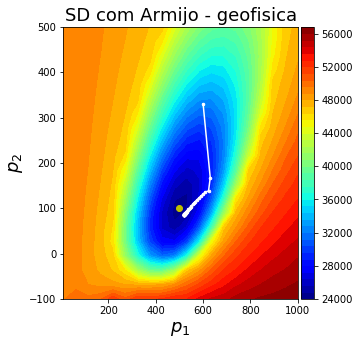

In [29]:
#plot
plt.figure(figsize=(5,5))
plt.plot(500., 100., 'oy')
plt.plot(p1_list, p2_list, '.w-', markersize=5)
plt.title('SD com Armijo - geofisica', fontsize=18)
plt.contourf(cylinder_data['p1'], cylinder_data['p2'], cylinder_data['phi_eq'], 40, cmap='jet')
plt.xlabel('$p_1$', fontsize=18)
plt.ylabel('$p_2$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.savefig('plot_SD_Armijo_geofisica.png', pad_inches=0.0)
plt.show()

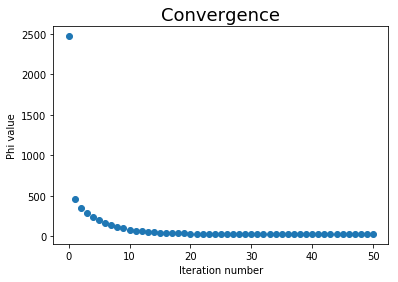

In [30]:
plt.title('Convergence', fontsize = 18)
plt.xlabel('Iteration number')
plt.ylabel('Phi value')
plt.plot(phi_list, 'o')
plt.savefig('convergence_SD_Armijo_geofisca.png', dpi=300)
plt.show()

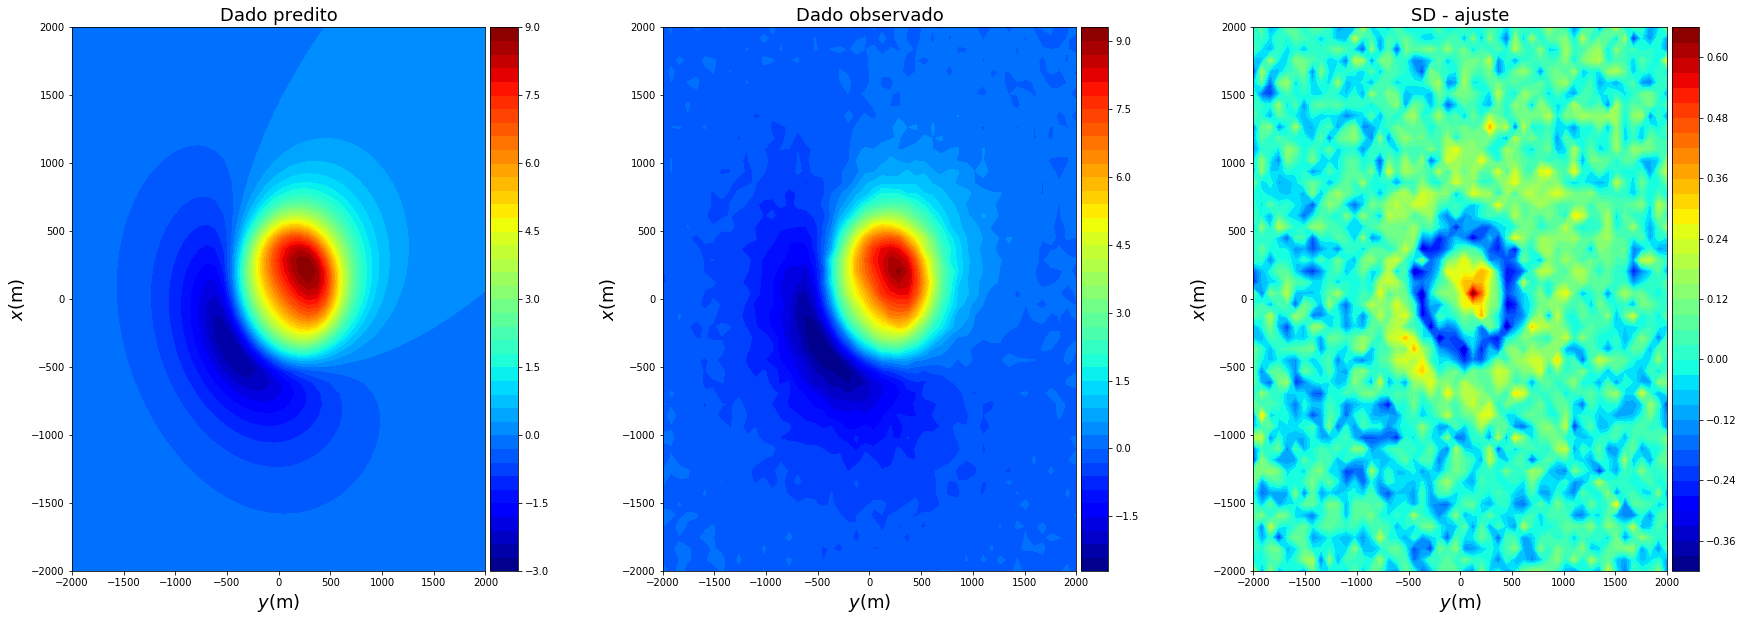

In [31]:
res = res.reshape(regular_grid['shape'])
xp = regular_grid['xp'].reshape(regular_grid['shape'])
yp = regular_grid['yp'].reshape(regular_grid['shape'])
dpred = cylinder_data['data'].reshape(regular_grid['shape'])
dobs = cylinder_data['data_noise'].reshape(regular_grid['shape'])

# plot
plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=18)
plt.contourf(yp, xp, dpred, 40, cmap='jet')
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=18)
plt.contourf(yp, xp, dobs, 40, cmap='jet')
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)

plt.subplot(1, 3, 3)
plt.title('SD - ajuste', fontsize=18)
plt.contourf(yp, xp, res, 40, cmap='jet')
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.savefig('plot_SD_armijo_ajuste.png', pad_inches=0.0)
plt.show()